In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from architecture.MLP import FCNet
from utils import get_data, plotter
from collections import OrderedDict
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import colors
from permute import permute_align
from scipy.cluster.hierarchy import leaves_list, linkage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

In [52]:
# convert model parameters to vectors
def model2vec(model):
    vec = []
    for p in model.parameters():
        vec.append(p.view(-1))
    vec = torch.cat(vec).view(-1, 1)
    return vec

# convert vectors to model parameters
def vec2model(vec, model):
    vec = vec.view(-1)
    vec = vec.to(device)
    model_dict = model.state_dict()
    state_dict = OrderedDict()
    start = 0
    for k, v in model_dict.items():
        end = start + v.numel()
        state_dict[k] = vec[start:end].view(v.shape)
        start = end
    model.load_state_dict(state_dict)
    return model

# given three vectors, return the x-y plane's basis they define and all 3 points in new basis
def get_plane(v0, v1, v2):
    v0 = v0.view(-1, 1)
    v1 = v1.view(-1, 1)
    v2 = v2.view(-1, 1)

    origin = v0
    x = v1 - origin # v1 = origin + x
    # d = (v2 - origin).x / |x|
    xnorm = torch.norm(x)
    d = torch.matmul(x.T, v2 - origin) / xnorm
    # v2 = origin + y + d.x/|x|
    y = v2 - origin - d * x / xnorm

    return origin, x, y, d

In [53]:
dataset = "pentagon"
width = 64

# Load data
train_loader, test_loader = get_data(dataset, 512)

# load the numpy logs
logs = np.load(f"logs/sigmoid/{dataset}/logs_s512_w{width}_d1.npy")

# choose 3 random indices from 0 to 50
indices = np.random.choice(50, 2, replace=False)

# reference
ref_idx = np.argmin(logs[:, 0])

# replace
# indices[0] = 7
# indices[1] = 25

print(indices)

# if indices[1] is the same as indices[0], choose another random index
while indices[1] == indices[0]:
    indices[1] = np.random.randint(0, 50)

[10 23]


In [54]:
# load both models
model0 = FCNet(2, width, 1, 1)
model1 = FCNet(2, width, 1, 1)

model0.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{indices[0]}.pth")
)
model1.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{indices[1]}.pth")
)

# model2 is average of model0 and model1 + noise
model2 = FCNet(2, width, 1, 1)
model2.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{indices[0]}.pth")
)
model2_dict = model2.state_dict()
for k, v in model2_dict.items():
    noise = torch.randn(v.shape) * 0.01
    model2_dict[k] = (model0.state_dict()[k] + model1.state_dict()[k]) / 2 + noise
model2.load_state_dict(model2_dict)

# convert models to vectors
vec0 = model2vec(model0)
vec1 = model2vec(model1)
vec2 = model2vec(model2)

origin, x, y, d = get_plane(vec0, vec1, vec2)
# testing
xhat = x / torch.norm(x)
yhat = y / torch.norm(y)
xnorm_ = torch.norm(x).item()
ynorm_ = torch.norm(y).item()
dnorm_ = d.item()

#print(xnorm, ynorm, dnorm)

# testing
x_mid = (dnorm_ + xnorm_) / 3
y_mid = ynorm_ / 3
x_min, x_max = x_mid - xnorm_, x_mid + xnorm_
y_min, y_max = y_mid - 10, y_mid + 10

#print(x_mid, y_mid)
print(x_min, x_max, y_min, y_max)

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                        np.arange(y_min, y_max, 0.5))
grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

-12.504444122314453 37.50968551635742 -9.947309707601866 10.052690292398134


In [55]:
# model at grid[i, j] is model2vec(vec0 + i * x + j * y)
model_ = FCNet(2, width, 1, 1)

def get_model(i, j):
    return vec2model(vec0 + i * xhat + j * yhat, model_)

# compute loss at grid[i, j]
def get_loss(i, j, loader):
    model = get_model(i, j)
    model.to(device).eval()
    loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()
        loss += torch.nn.functional.binary_cross_entropy_with_logits(model(x), y, reduction="mean")
        loss /= len(loader)
    return loss.item()

In [56]:
# compute loss at grid[i, j] for all i, j
loss_grid_train = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_train[i, j] = get_loss(xx[i, j], yy[i, j], train_loader)

loss_grid_test = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        loss_grid_test[i, j] = get_loss(xx[i, j], yy[i, j], test_loader)

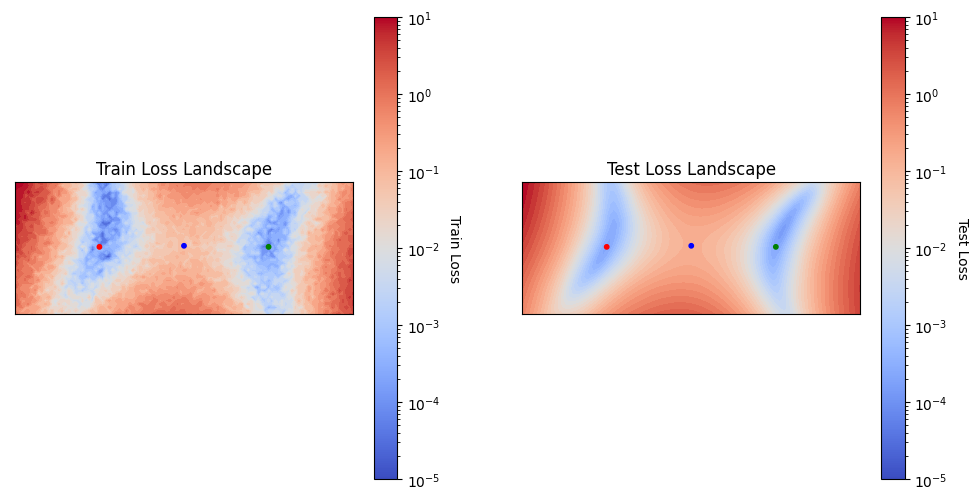

In [57]:
# plot train and test loss landscapes
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

vmin = -5
vmax = 1 
# contour plot on log scale
ax[0].contourf(xx, yy, np.log(loss_grid_train), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# contour plot on log scale
ax[1].contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[0])
cbar.ax.set_ylabel("Train Loss", rotation=270, labelpad=15)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[1])
cbar.ax.set_ylabel("Test Loss", rotation=270, labelpad=15)

#print(xnorm, ynorm, dnorm)

ax[0].scatter([0, xnorm_, dnorm_], [0, 0, ynorm_], c=["red", "green", "blue"], s=10,)
ax[1].scatter([0, xnorm_, dnorm_], [0, 0, ynorm_], c=["red", "green", "blue"], s=10,)
ax[0].set_title("Train Loss Landscape")
ax[1].set_title("Test Loss Landscape")

# remove x, y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# # test aspect ratio
# ax[0].set_aspect('auto')
# ax[1].set_aspect('auto')
plt.show()

In [58]:
def sample_model(vec0, vec1, model2):
    vec2 = model2vec(model2).to(device)
    vec0 = vec0.to(device)
    vec1 = vec1.to(device)

    norm_2_0 = torch.norm(vec2 - vec0).item()
    norm_2_1 = torch.norm(vec2 - vec1).item()
    #print(f"norms: {norm_2_0}, {norm_2_1}")
    # pick a number between 0 and 1
    alpha = torch.rand(1).item()
    #print(f"alpha: {alpha}")
    # transition value
    trans = norm_2_0 / (norm_2_0 + norm_2_1)
    #print(f"trans: {trans}")
    # pick a model based on alpha
    if alpha <= trans:
        # sample a model along the path 0 -> 2
        alpha = alpha/trans
        model2 = vec2model((1 - alpha) * vec0 + alpha * vec2, model2)
    else:
        # sample a model along the path 2 -> 1
        alpha = (alpha - trans)/(1 - trans)
        model2 = vec2model((1 - alpha) * vec2 + alpha * vec1, model2)
    return model2

In [59]:
# re-train model2 such that expected loss along model 0 -> 1 -> 2 is minimized
for _ in range(100):
    # Define the loss function
    criterion = torch.nn.BCEWithLogitsLoss()

    # Define the optimizer
    optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-2)

    # sample a model along the path 0 -> 1 -> 2
    model2 = sample_model(vec0, vec1, model2)

    # Train the model
    model2.to(device)
    model2.train()
    for epoch in range(1):
        for x, y in train_loader:
            # model has 1 output
            y = y.unsqueeze(1).float()
            # Forward pass
            optimizer.zero_grad()
            y_pred = model2(x.to(device))
            loss = criterion(y_pred, y.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

In [60]:
# convert models to vectors
vec0 = model2vec(model0).to(device)
vec1 = model2vec(model1).to(device)
vec2 = model2vec(model2).to(device)

origin, x, y, d = get_plane(vec0, vec1, vec2)
# testing
xhat = x / torch.norm(x)
yhat = y / torch.norm(y)
xnorm = torch.norm(x).item()
ynorm = torch.norm(y).item()
dnorm = d.item()

# testing
x_mid = (dnorm + xnorm) / 3
y_mid = ynorm / 3
x_min, x_max = x_mid - xnorm, x_mid + xnorm
y_min, y_max = y_mid - 10, y_mid + 10

xx_, yy_ = np.meshgrid(np.arange(x_min, x_max, 0.5),
                        np.arange(y_min, y_max, 0.5))
grid = torch.from_numpy(np.c_[xx_.ravel(), yy_.ravel()]).float().to(device)

# model at grid[i, j] is model2vec(vec0 + i * x + j * y)
model_ = FCNet(2, width, 1, 1)

def get_model(i, j):
    return vec2model(vec0 + i * xhat + j * yhat, model_)

# compute loss at grid[i, j]
def get_loss(i, j, loader):
    model = get_model(i, j)
    model.to(device).eval()
    loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()
        loss += torch.nn.functional.binary_cross_entropy_with_logits(model(x), y, reduction="mean")
        loss /= len(loader)
    return loss.item()

# compute loss at grid[i, j] for all i, j
loss_grid_train_ = np.zeros(xx_.shape)
for i in range(xx_.shape[0]):
    for j in range(xx_.shape[1]):
        loss_grid_train_[i, j] = get_loss(xx_[i, j], yy_[i, j], train_loader)

loss_grid_test_ = np.zeros(xx_.shape)
for i in range(xx_.shape[0]):
    for j in range(xx_.shape[1]):
        loss_grid_test_[i, j] = get_loss(xx_[i, j], yy_[i, j], test_loader)

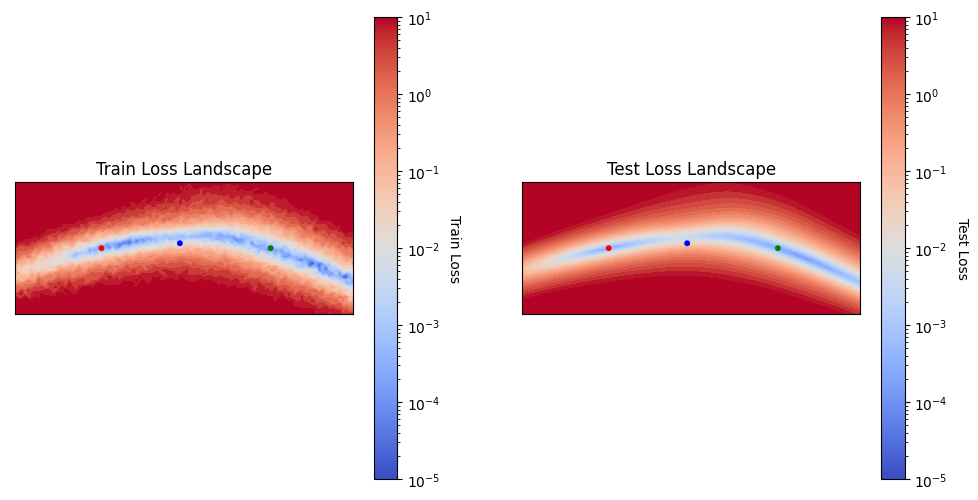

In [61]:
# plot train and test loss landscapes
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

vmin = -5
vmax = 1 
# contour plot on log scale
ax[0].contourf(xx_, yy_, np.log(loss_grid_train_), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# contour plot on log scale
ax[1].contourf(xx_, yy_, np.log(loss_grid_test_), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# colorbar in log scale
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[0])
cbar.ax.set_ylabel("Train Loss", rotation=270, labelpad=15)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), ax=ax[1])
cbar.ax.set_ylabel("Test Loss", rotation=270, labelpad=15)

ax[0].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[1].scatter([0, xnorm, dnorm], [0, 0, ynorm], c=["red", "green", "blue"], s=10,)
ax[0].set_title("Train Loss Landscape")
ax[1].set_title("Test Loss Landscape")

# remove x, y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# # test aspect ratio
# ax[0].set_aspect('auto')
# ax[1].set_aspect('auto')
plt.show()

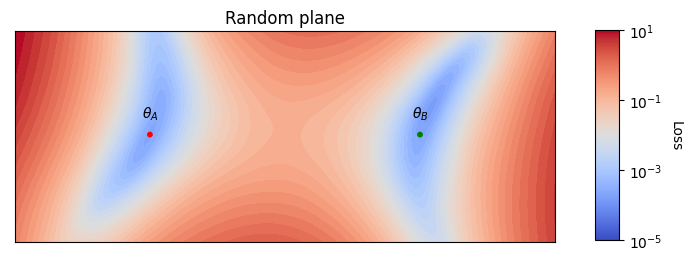

In [67]:
# plot random plane
vmin = -5
vmax = 1

# contour plot on log scale
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.contourf(xx, yy, np.log(loss_grid_test), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# text
ax.text(0, 0+2, "$\\theta_A$", fontsize=10, horizontalalignment='center', verticalalignment='center')
ax.text(xnorm_, 0+2, "$\\theta_B$", fontsize=10, horizontalalignment='center', verticalalignment='center')

ax.scatter([0, xnorm_], [0, 0], c=["red", "green"], s=10,)
ax.set_title("Random plane")

# remove x, y ticks
ax.set_xticks([])
ax.set_yticks([])
# aspect ratio
ax.set_aspect('equal')

# common colorbar (log scale)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), cax=cbar_ax)
cbar.ax.set_ylabel("Loss", rotation=270, labelpad=15)

plt.savefig("random_plane.png", dpi=600, bbox_inches='tight')

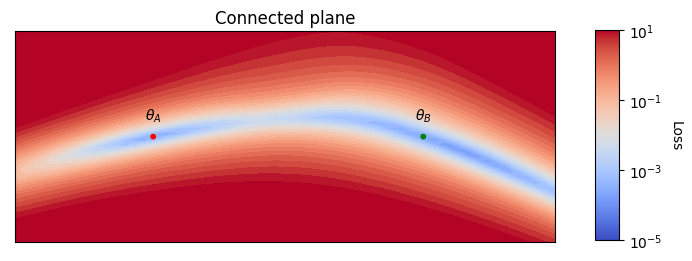

In [68]:
# plot random plane
vmin = -5
vmax = 1

# contour plot on log scale
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.contourf(xx_, yy_, np.log(loss_grid_test_), cmap=cm.coolwarm, levels=40, interpolation="none", vmin=vmin, vmax=vmax)

# text
ax.text(0, 0+2, "$\\theta_A$", fontsize=10, horizontalalignment='center', verticalalignment='center')
ax.text(xnorm, 0+2, "$\\theta_B$", fontsize=10, horizontalalignment='center', verticalalignment='center')

ax.scatter([0, xnorm], [0, 0], c=["red", "green"], s=10,)
ax.set_title("Connected plane")

# remove x, y ticks
ax.set_xticks([])
ax.set_yticks([])
# aspect ratio
ax.set_aspect('equal')

# common colorbar (log scale)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin = 10**vmin, vmax=10**vmax), cmap=cm.coolwarm), cax=cbar_ax)
cbar.ax.set_ylabel("Loss", rotation=270, labelpad=15)

plt.savefig("connected_plane.png", dpi=600, bbox_inches='tight')